In [1]:
from curl_sac import RadSacAgent

import numpy as np
import torch
import argparse
import os
import math
import gym
import sys
import random
import time
import json
import dmc2gym
import copy
import retro
from pathlib import Path
import weightwatcher as ww


import utils
from logger import Logger
from video import VideoRecorder

from curl_sac import RadSacAgent
from torchvision import transforms
import data_augs as rad

In [2]:
def parse_args(file_path):
    args = json.load(open(os.path.join(file_path, 'args.json')))
    return args

def make_agent(obs_shape, action_shape, args, device):
    if args.agent == 'rad_sac':
        return RadSacAgent(
            obs_shape=obs_shape,
            action_shape=action_shape,
            device=device,
            hidden_dim=args.hidden_dim,
            discount=args.discount,
            init_temperature=args.init_temperature,
            alpha_lr=args.alpha_lr,
            alpha_beta=args.alpha_beta,
            actor_lr=args.actor_lr,
            actor_beta=args.actor_beta,
            actor_log_std_min=args.actor_log_std_min,
            actor_log_std_max=args.actor_log_std_max,
            actor_update_freq=args.actor_update_freq,
            critic_lr=args.critic_lr,
            critic_beta=args.critic_beta,
            critic_tau=args.critic_tau,
            critic_target_update_freq=args.critic_target_update_freq,
            encoder_type=args.encoder_type,
            encoder_feature_dim=args.encoder_feature_dim,
            encoder_lr=args.encoder_lr,
            encoder_tau=args.encoder_tau,
            num_layers=args.num_layers,
            num_filters=args.num_filters,
            log_interval=args.log_interval,
            detach_encoder=args.detach_encoder,
            latent_dim=args.latent_dim,
            data_augs=args.data_augs
        )
    else:
        assert 'agent is not supported: %s' % args.agent







In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
args = parse_args('tmp/cartpole-swingup-12-03-im84-b128-s23-pixel')
args = dotdict(args)
if args['seed'] == -1: 
    args.__dict__["seed"] = np.random.randint(1,1000000)
utils.set_seed_everywhere(args['seed'])

pre_transform_image_size = args['pre_transform_image_size'] if 'crop' in args['data_augs'] else args['image_size']
pre_image_size = args['pre_transform_image_size'] # record the pre transform image size for translation

env = dmc2gym.make(
    domain_name=args.domain_name,
    task_name=args.task_name,
    seed=args.seed,
    visualize_reward=False,
    from_pixels=(args.encoder_type == 'pixel'),
    height=pre_transform_image_size,
    width=pre_transform_image_size,
    frame_skip=args.action_repeat
)

env.seed(args['seed'])

# stack several consecutive frames together
if args.encoder_type == 'pixel':
    env = utils.FrameStack(env, k=args.frame_stack)
    

# # make directory
# ts = time.gmtime() 
# ts = time.strftime("%m-%d", ts)    
# env_name = args.domain_name + '-' + args.task_name
# exp_name = env_name + '-' + ts + '-im' + str(args.image_size) +'-b'  \
# + str(args.batch_size) + '-s' + str(args.seed)  + '-' + args.encoder_type
# args.work_dir = args.work_dir + '/'  + exp_name

# utils.make_dir(args.work_dir)
# video_dir = utils.make_dir(os.path.join(args.work_dir, 'video'))
# model_dir = utils.make_dir(os.path.join(args.work_dir, 'model'))
# buffer_dir = utils.make_dir(os.path.join(args.work_dir, 'buffer'))

# video = VideoRecorder(video_dir if args.save_video else None)

# with open(os.path.join(args.work_dir, 'args.json'), 'w') as f:
#     json.dump(vars(args), f, sort_keys=True, indent=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

action_shape = env.action_space.shape

if args.encoder_type == 'pixel':
    obs_shape = (3*args.frame_stack, args.image_size, args.image_size)
    pre_aug_obs_shape = (3*args.frame_stack,pre_transform_image_size,pre_transform_image_size)
else:
    obs_shape = env.observation_space.shape
    pre_aug_obs_shape = obs_shape

replay_buffer = utils.ReplayBuffer(
    obs_shape=pre_aug_obs_shape,
    action_shape=action_shape,
    capacity=args.replay_buffer_capacity,
    batch_size=args.batch_size,
    device=device,
    image_size=args.image_size,
    pre_image_size=pre_image_size,
)

agent = make_agent(
    obs_shape=obs_shape,
    action_shape=action_shape,
    args=args,
    device=device
)

INFO:absl:MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.
INFO:absl:Failed to import OpenGL backend: glfw
INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
INFO:absl:Successfully imported OpenGL backend: egl
INFO:absl:MuJoCo library version is: 200
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [5]:
agent.load('tmp/cartpole-swingup-12-03-im84-b128-s23-pixel/model', 0)

In [7]:
# from utils import prepare_model


watcher = ww.WeightWatcher(model=agent.actor)
details = watcher.analyze()
details.to_csv("esd_plot.csv")
# check csv to get which layers to input into the analyze function's arg in the next lines
# esd_layer_ = watcher.get_esd()

summary = watcher.get_summary(details)
# layers_6 = [127,142,90,71,48,46] # rank and choose from esd_plot.csv
# details = watcher.analyze(plot=True, randomize=True, savefig="esd_plot_figure", layers=layers_6)
summary

INFO:weightwatcher:

python      version 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]
numpy       version 1.19.2
tensforflow version 2.7.0
keras       version 2.7.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img
Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img
Assuming nested distributions


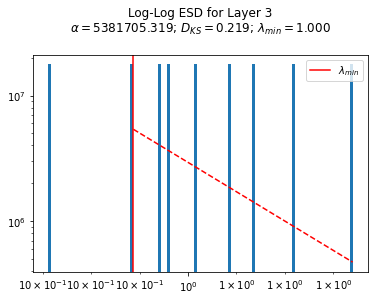

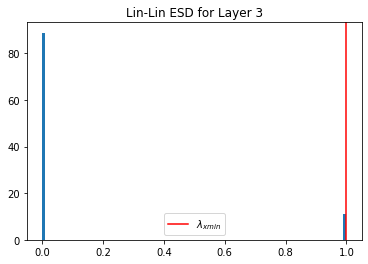

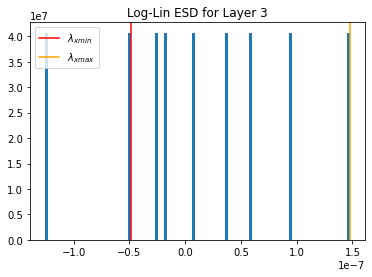

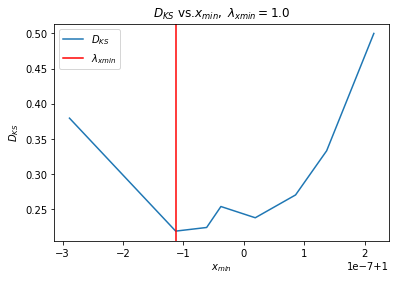

<Figure size 432x288 with 0 Axes>

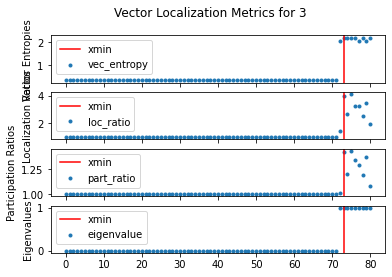

<Figure size 432x288 with 0 Axes>

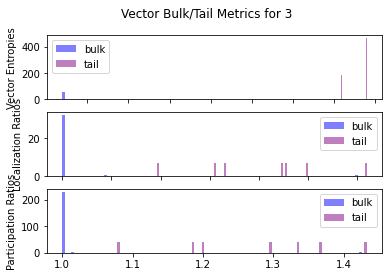

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


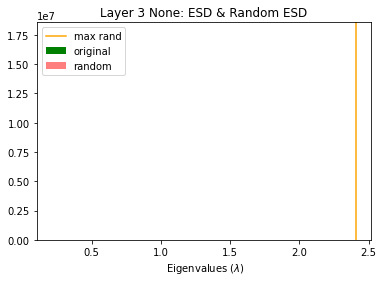

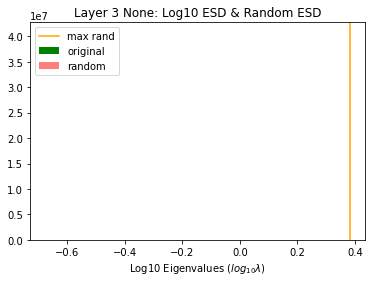

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


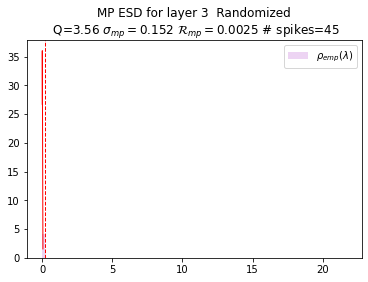

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(p * np.log(p)) / np.log(rank)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(p * np.log(p)) / np.log(rank)
Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1409: RuntimeWarning: invalid value encountered in double_scalars
  float(gammainc(1-self.alpha,self.Lambda*self.xmin)))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1408: RuntimeWarning: overflow encountered in double_scalars
  C = ( self.Lambda**(1-self.alpha) /


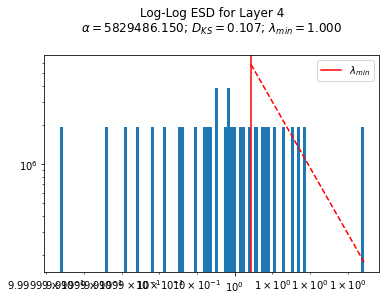

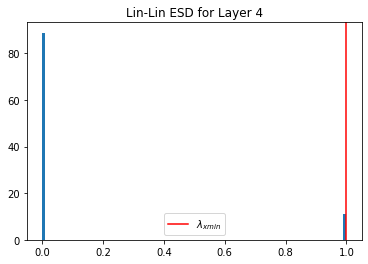

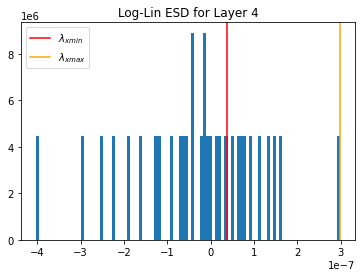

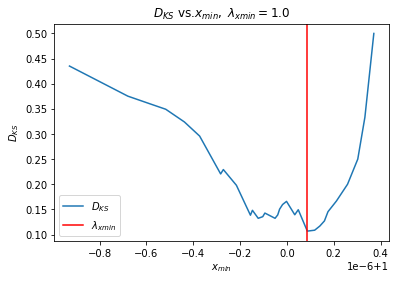

<Figure size 432x288 with 0 Axes>

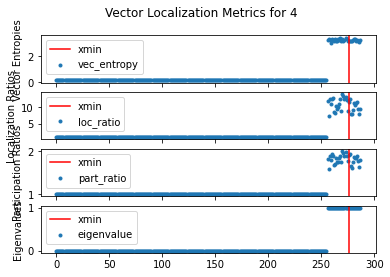

<Figure size 432x288 with 0 Axes>

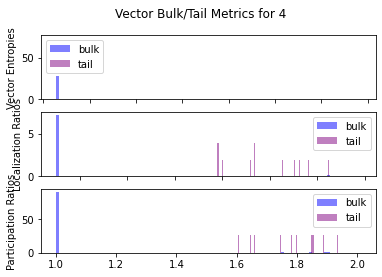

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


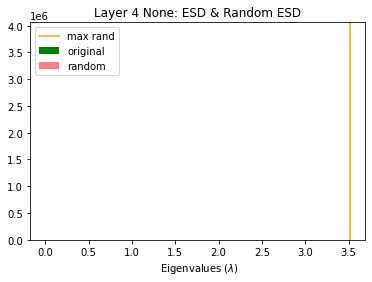

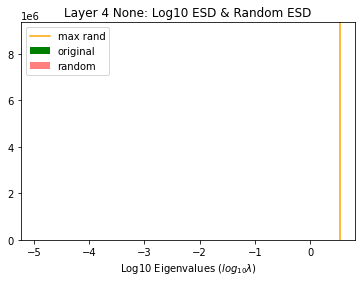

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


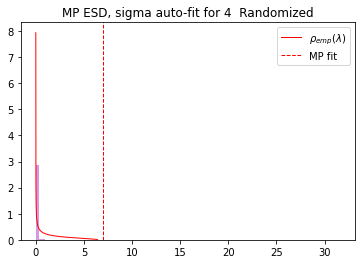

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


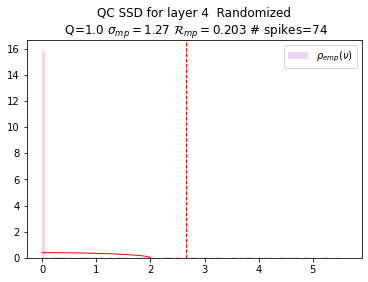

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(p * np.log(p)) / np.log(rank)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(p * np.log(p)) / np.log(rank)


Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1409: RuntimeWarning: invalid value encountered in double_scalars
  float(gammainc(1-self.alpha,self.Lambda*self.xmin)))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1408: RuntimeWarning: overflow encountered in double_scalars
  C = ( self.Lambda**(1-self.alpha) /


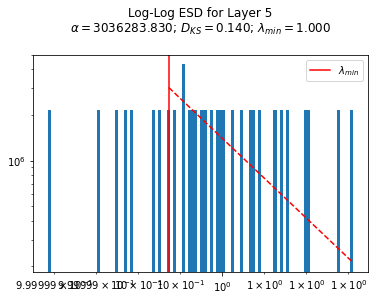

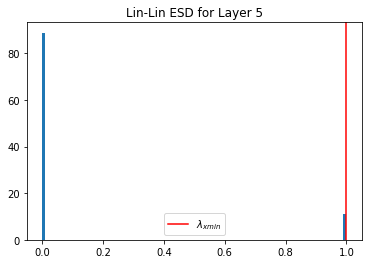

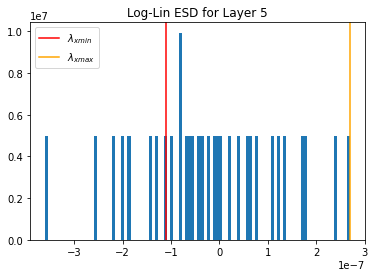

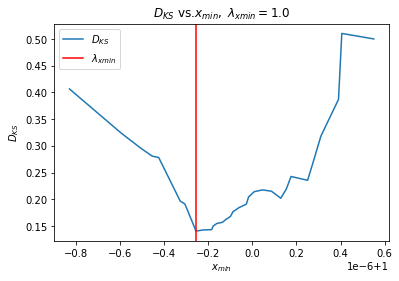

<Figure size 432x288 with 0 Axes>

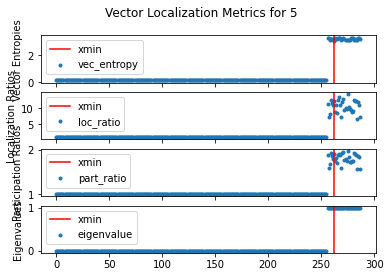

<Figure size 432x288 with 0 Axes>

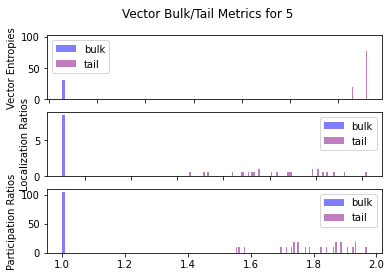

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


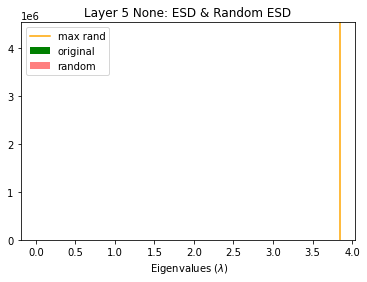

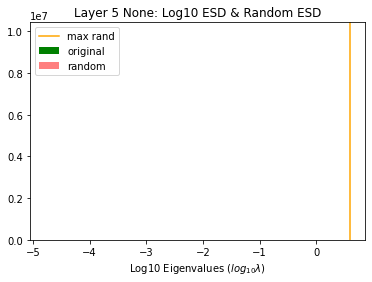

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


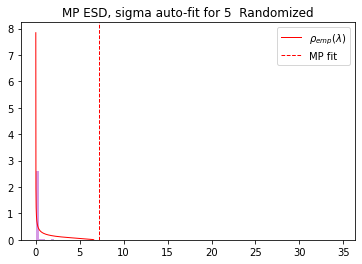

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


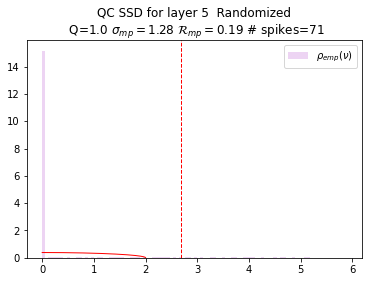

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(p * np.log(p)) / np.log(rank)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(p * np.log(p)) / np.log(rank)


Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1409: RuntimeWarning: invalid value encountered in double_scalars
  float(gammainc(1-self.alpha,self.Lambda*self.xmin)))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1408: RuntimeWarning: overflow encountered in double_scalars
  C = ( self.Lambda**(1-self.alpha) /


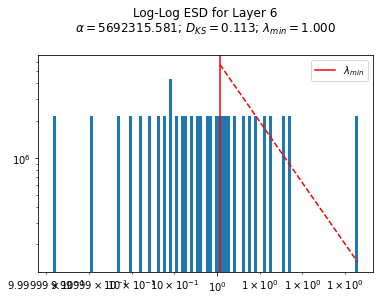

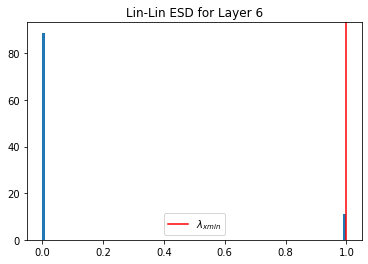

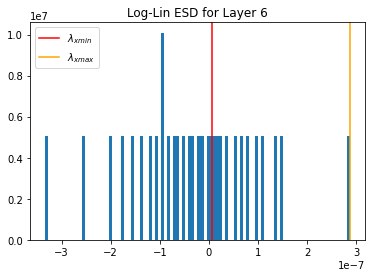

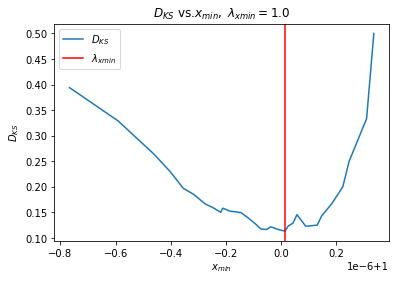

<Figure size 432x288 with 0 Axes>

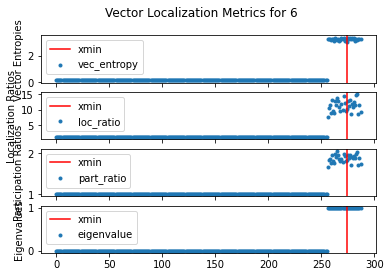

<Figure size 432x288 with 0 Axes>

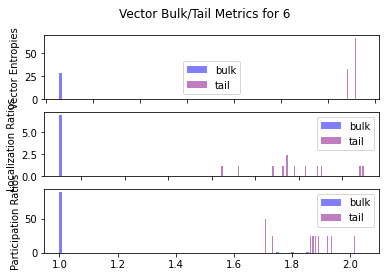

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


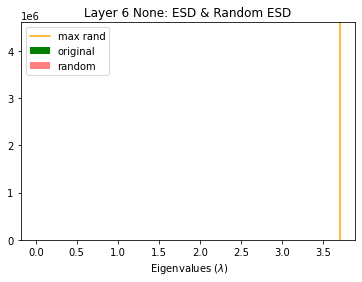

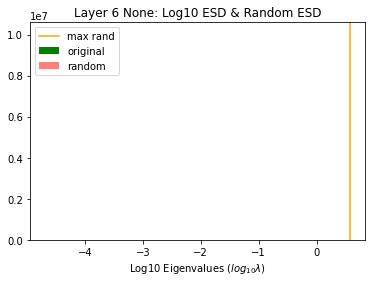

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


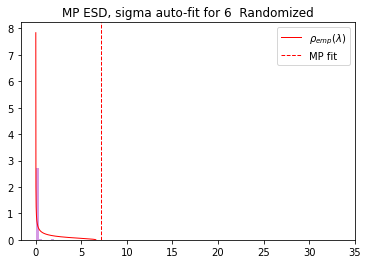

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


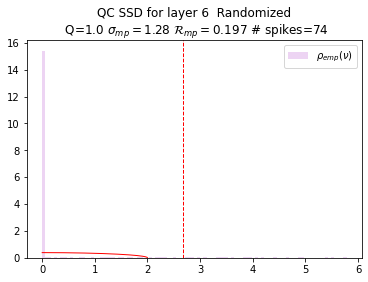

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(p * np.log(p)) / np.log(rank)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(p * np.log(p)) / np.log(rank)


Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1409: RuntimeWarning: invalid value encountered in double_scalars
  float(gammainc(1-self.alpha,self.Lambda*self.xmin)))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1408: RuntimeWarning: overflow encountered in double_scalars
  C = ( self.Lambda**(1-self.alpha) /
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1409: RuntimeWarning: divide by zero encountered in double_scalars
  float(gammainc(1-self.alpha,self.Lambda*self.xmin)))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1808: RuntimeWarning: invalid value encountered in subtract
  ( (loglikelihoods1-loglikelihoods2) - mean_diff)**2


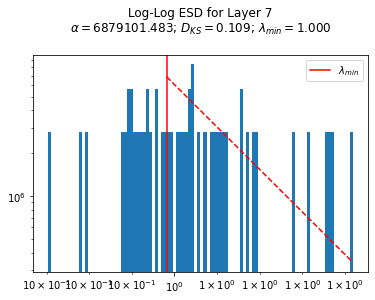

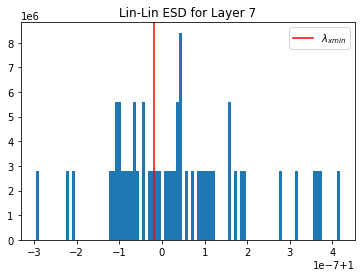

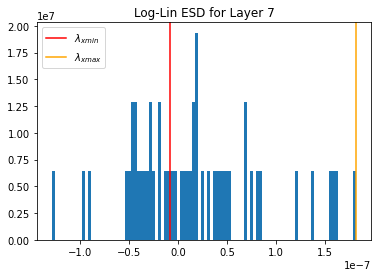

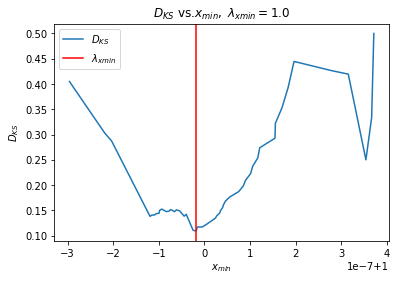

<Figure size 432x288 with 0 Axes>

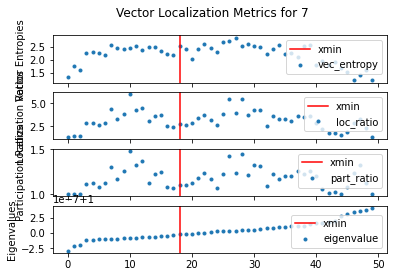

<Figure size 432x288 with 0 Axes>

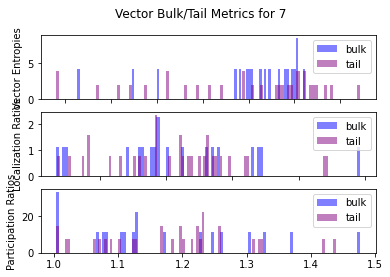

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


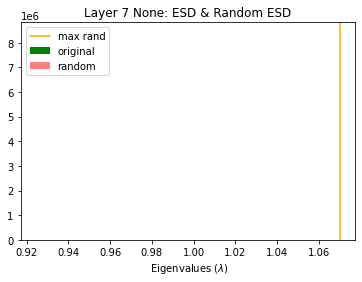

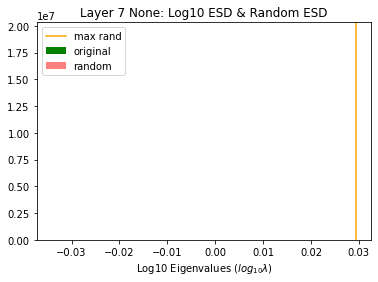

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


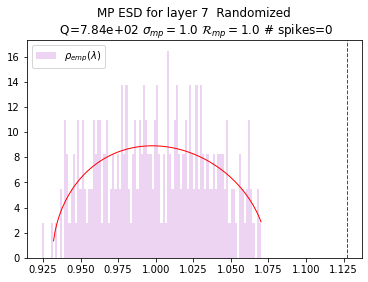

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1409: RuntimeWarning: invalid value encountered in double_scalars
  float(gammainc(1-self.alpha,self.Lambda*self.xmin)))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1408: RuntimeWarning: overflow encountered in double_scalars
  C = ( self.Lambda**(1-self.alpha) /
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1409: RuntimeWarning: divide by zero encountered in double_scalars
  float(gammainc(1-self.alpha,self.Lambda*self.xmin)))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1808: RuntimeWarning: invalid value encountered in subtract
  ( (loglikelihoods1-loglikelihoods2) - mean_diff)**2


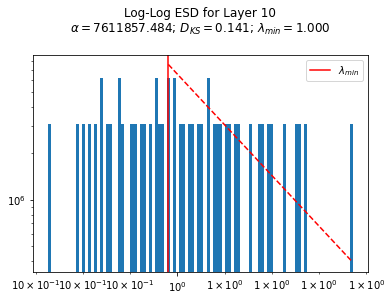

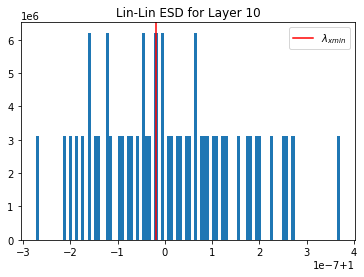

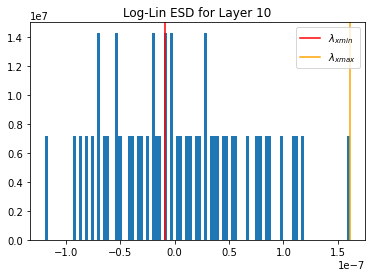

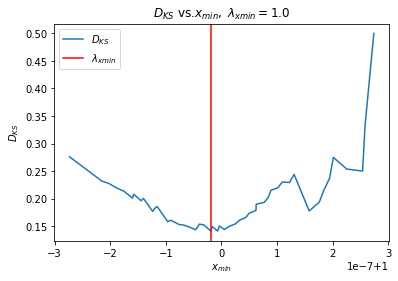

<Figure size 432x288 with 0 Axes>

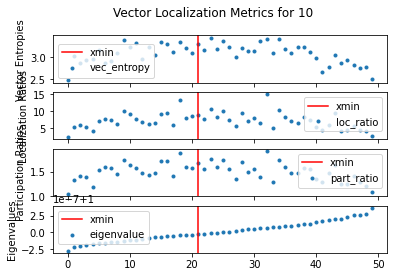

<Figure size 432x288 with 0 Axes>

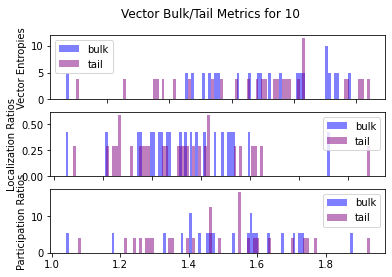

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


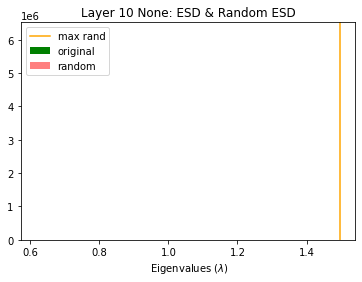

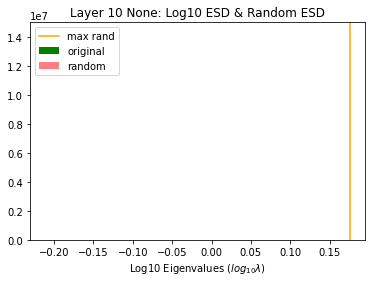

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


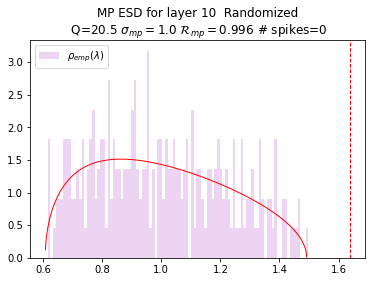

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1409: RuntimeWarning: invalid value encountered in double_scalars
  float(gammainc(1-self.alpha,self.Lambda*self.xmin)))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1408: RuntimeWarning: overflow encountered in double_scalars
  C = ( self.Lambda**(1-self.alpha) /
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1409: RuntimeWarning: divide by zero encountered in double_scalars
  float(gammainc(1-self.alpha,self.Lambda*self.xmin)))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1808: RuntimeWarning: invalid value encountered in subtract
  ( (loglikelihoods1-loglikelihoods2) - mean_diff)**2


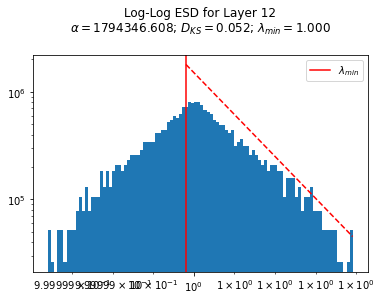

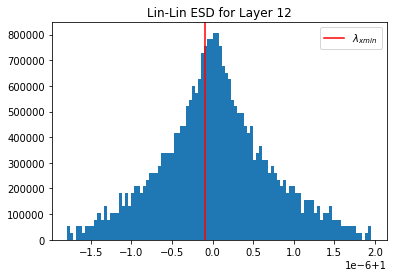

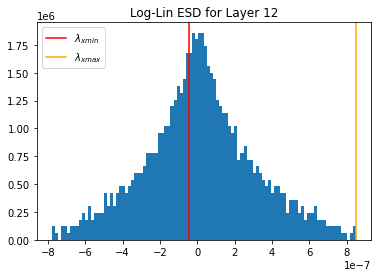

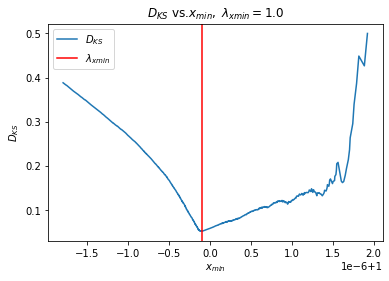

<Figure size 432x288 with 0 Axes>

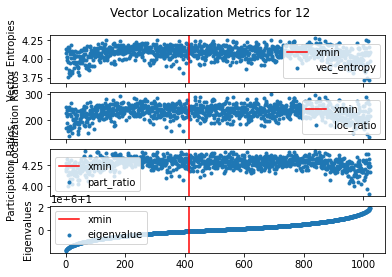

<Figure size 432x288 with 0 Axes>

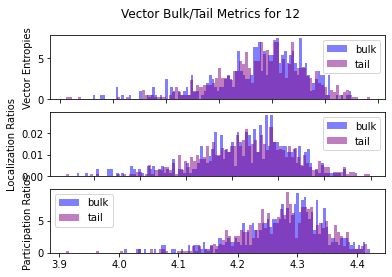

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


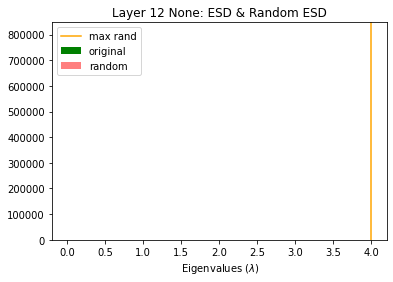

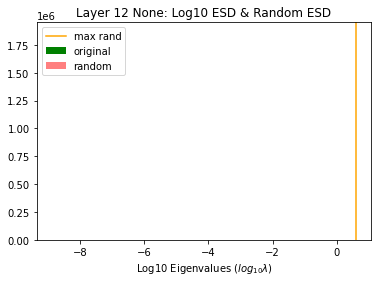

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


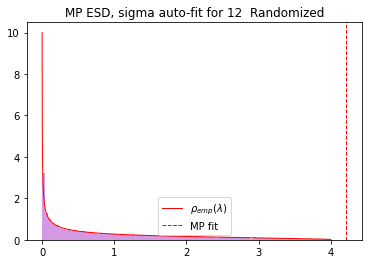

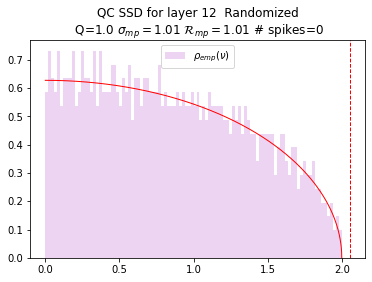

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1409: RuntimeWarning: invalid value encountered in double_scalars
  float(gammainc(1-self.alpha,self.Lambda*self.xmin)))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1408: RuntimeWarning: overflow encountered in double_scalars
  C = ( self.Lambda**(1-self.alpha) /


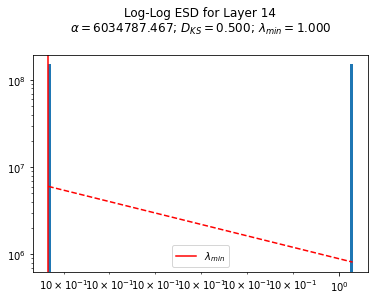

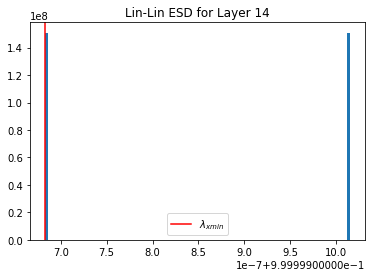

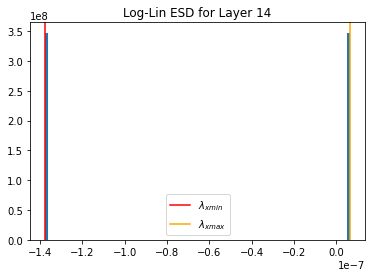

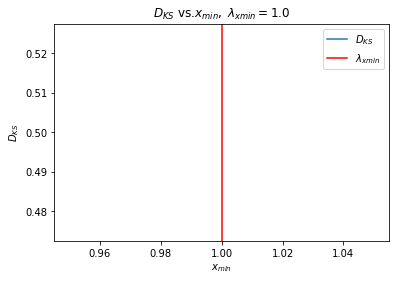

<Figure size 432x288 with 0 Axes>

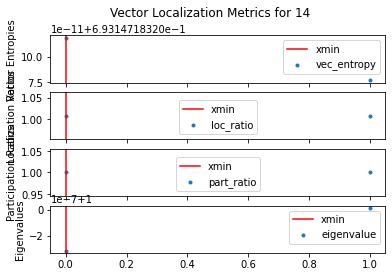

<Figure size 432x288 with 0 Axes>

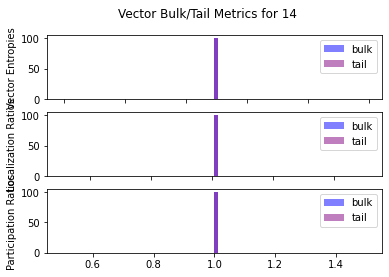

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


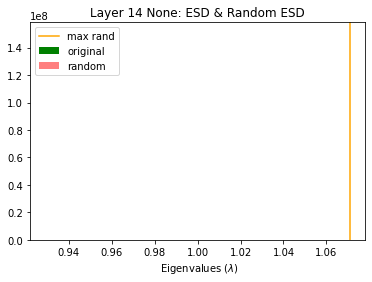

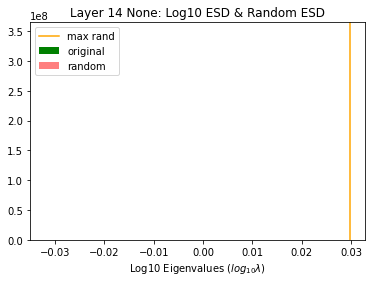

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


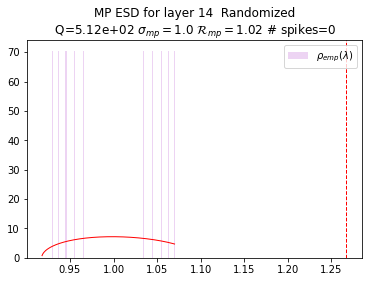

<Figure size 432x288 with 0 Axes>

In [9]:
details = watcher.analyze(randomize=True, plot=True)